In [1]:
import cv2 as cv
from matplotlib import pyplot as plt

### 1. Реалізація обчислення гістрограми яскравості для кольорового зображення

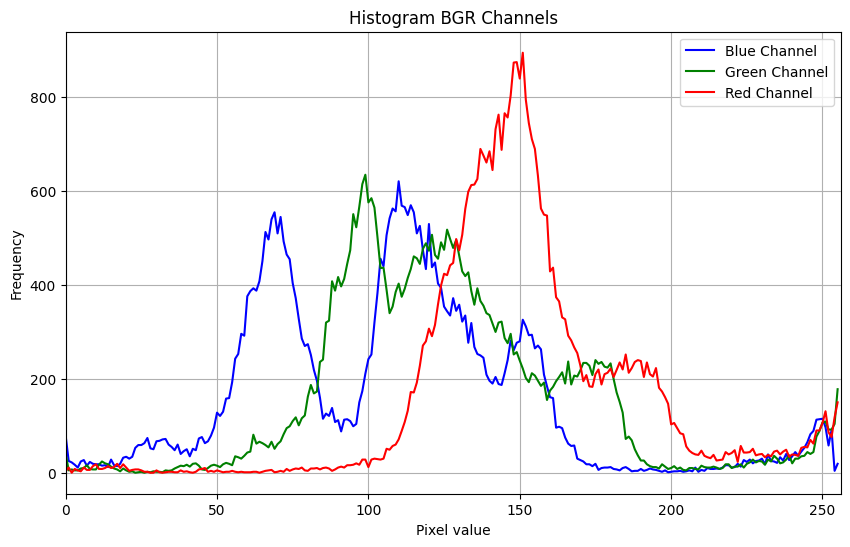

In [62]:
image = cv.imread('images/1.jpg')

channels = cv.split(image)
histSize = 256
histRange = (0, 256)
accumulate = False

colors = ['b', 'g', 'r']
channels_names = ["Blue", "Green", "Red"]

plt.figure(figsize=(10,6))
for i, color in enumerate(colors):
    hist = cv.calcHist([channels[i]], [0], None, [histSize], histRange, accumulate=accumulate)
    plt.plot(hist, color=color, label=f"{channels_names[i]} Channel")
    plt.xlim([0, 256])

plt.title('Histogram BGR Channels')
plt.xlabel('Pixel value')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

(-0.5, 199.5, 199.5, -0.5)

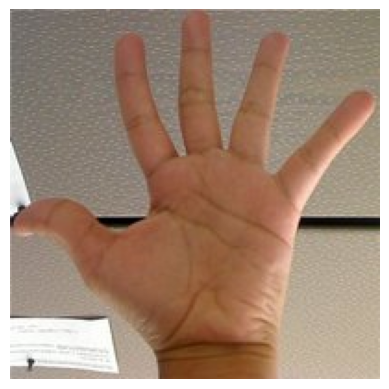

In [61]:
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.axis('off')